In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [4]:
# date-time parsing function for loading the dataset
# def parser(x):
# 	return datetime.strptime('190'+x, '%Y-%m')

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime(x, '%m/%Y')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


## Data Preprocessing

In [5]:
# load dataset
# series = read_csv('../data/sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = read_csv('../data/theft_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head(5)

Date
2001-01-01    5125
2001-02-01    4429
2001-03-01    5024
2001-04-01    4887
2001-05-01    5148
Name: Thefts, dtype: int64

In [6]:
# transform data to be stationary
raw_values = series.values
## now raw_values is ndarray, instead of Series
print(raw_values[:5])
print(raw_values.shape)

diff_values = difference(raw_values, 1)
print(diff_values[:5])
print(diff_values.shape)
## now we have 35 data points

[5125 4429 5024 4887 5148]
(210,)
0   -696
1    595
2   -137
3    261
4    138
dtype: int64
(209,)


### Comment:
The tutorial says it is easier to deal with data that is stationary. Stationary data does not have seasonality or trend.

In [7]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
supervised_values[:5,:]

array([[   0., -696.],
       [-696.,  595.],
       [ 595., -137.],
       [-137.,  261.],
       [ 261.,  138.]])

### Comment:
The data now becomes supervised learning setting: [X, y], with y being the output and X being the input. y is one lag (in this case lag = 1) ahead of X. So the prediction problem now becomes something Neural Network is familiar with: predicting y using X. 

In [13]:
# split data into train and test-sets
train, test = supervised_values[0:-70], supervised_values[-70:]
print(train.shape)
print(test.shape)

(139, 2)
(70, 2)


In [14]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [15]:
print(train_scaled.min())
print(train_scaled.max())
print(train_scaled[:5])

-1.0
0.9999999999999998
[[-0.29092382 -0.85494327]
 [-0.85494327  0.19124797]
 [ 0.19124797 -0.40194489]
 [-0.40194489 -0.07941653]
 [-0.07941653 -0.17909238]]


### Comment:
The data now is now mapped into [-1,1] <br>
The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

## Build the model, Train and Predict

In [16]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
    # Split the data into X (input) and y (output)
	X = X.reshape(X.shape[0], 1, X.shape[1])
    # reshape into the shape [n_samples,timestep_size, n_features]
    # timestep_size: how many time points that you treat as one
    # n_samples: int(total time points / timestep)
    # n_features: the number of separate meaures observed 
    # at the time of observation
    
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
    
    
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [17]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Month=1, Predicted=2964.518308, Expected=2705.000000
Month=2, Predicted=2707.598439, Expected=2381.000000
Month=3, Predicted=2410.186578, Expected=2217.000000
Month=4, Predicted=2245.510046, Expected=2225.000000
Month=5, Predicted=2235.285115, Expected=1978.000000
Month=6, Predicted=1999.070615, Expected=1507.000000
Month=7, Predicted=1559.038545, Expected=1873.000000
Month=8, Predicted=1867.958947, Expected=1987.000000
Month=9, Predicted=1961.514249, Expected=2532.000000
Month=10, Predicted=2466.840744, Expected=2460.000000
Month=11, Predicted=2411.967983, Expected=3006.000000
Month=12, Predicted=2931.320156, Expected=3089.000000
Month=13, Predicted=3025.742287, Expected=2732.000000
Month=14, Predicted=2721.118613, Expected=2454.000000
Month=15, Predicted=2471.208761, Expected=2281.000000
Month=16, Predicted=2303.582406, Expected=2002.000000
Month=17, Predicted=2036.739323, Expected=1853.000000
Month=18, Predicted=1881.775385, Expected=1654.000000
Month=19, Predicted=1682.270817, Expe

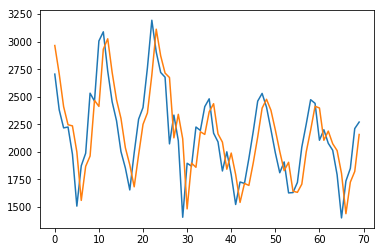

In [20]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 5, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-70:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-70:])
pyplot.plot(predictions)
pyplot.show()

In [31]:
def try_neurons_batch(batch_size = 1, num_neurons = 4, num_train = 70, rand = False):
    series = read_csv('../data/theft_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    if rand:
        import random
        rand = random.sample(range(200,30000),series.shape[0])
        series = Series(data = rand, index=series.index)
    
    raw_values = series.values
    diff_values = difference(raw_values, 1)    
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # split data into train and test-sets
    train, test = supervised_values[0:-num_train], supervised_values[-num_train:]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 5, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-num_train:], predictions))
    print('Test RMSE: %.3f' % rmse)
    # line plot of observed vs predicted
#     pyplot.plot(raw_values[-num_train:])
#     pyplot.plot(predictions)
#     pyplot.show()
    return(rmse)

Test RMSE: 11846.791


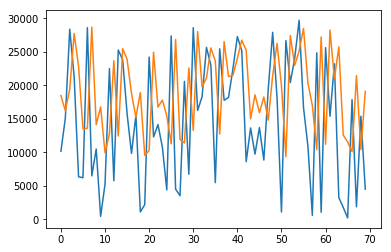

In [32]:
try_neurons_batch(batch_size=1, num_neurons=8, rand = True)

Test RMSE: 280.967


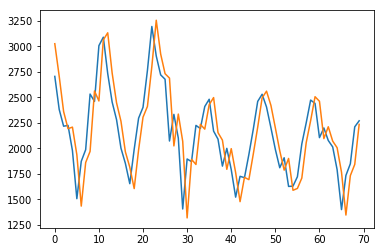

In [35]:
try_neurons_batch(batch_size=1, num_neurons=8, rand = False)

Test RMSE: 269.156


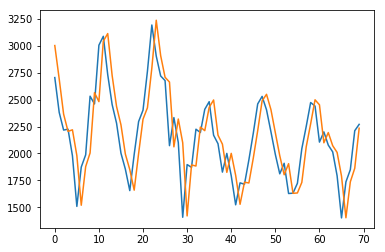

In [34]:
try_neurons_batch(batch_size=2, num_neurons=8, rand = False)

In [18]:
# For a single-input model with 2 classes (binary classification):

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
import numpy as np
data = np.random.random((1000, 100))
labels = np.random.randint(2, size=(1000, 1))

# Train the model, iterating on the data in batches of 32 samples
model.fit(data, labels, epochs=10, batch_size=32)


Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7242 - acc: 0.4960
Epoch 2/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.7037 - acc: 0.5180
Epoch 3/10
1000/1000 [==============================] - 0s 87us/step - loss: 0.7000 - acc: 0.5160
Epoch 4/10
1000/1000 [==============================] - 0s 82us/step - loss: 0.6938 - acc: 0.5250
Epoch 5/10
1000/1000 [==============================] - 0s 85us/step - loss: 0.6898 - acc: 0.5270
Epoch 6/10
1000/1000 [==============================] - 0s 82us/step - loss: 0.6862 - acc: 0.5490
Epoch 7/10
1000/1000 [==============================] - 0s 83us/step - loss: 0.6813 - acc: 0.5600
Epoch 8/10
1000/1000 [==============================] - 0s 81us/step - loss: 0.6778 - acc: 0.5650
Epoch 9/10
1000/1000 [==============================] - 0s 81us/step - loss: 0.6764 - acc: 0.5700
Epoch 10/10
1000/1000 [==============================] - 0s 83us/step - loss: 0.6721 - acc: 0.5700


In [19]:
data.shape

(1000, 100)

In [21]:
# For a single-input model with 10 classes (categorical classification):
import keras
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
import numpy as np
data = np.random.random((1000, 100))
labels = np.random.randint(10, size=(1000, 1))

# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(labels, num_classes=10)

# Train the model, iterating on the data in batches of 32 samples
model.fit(data, one_hot_labels, epochs=10, batch_size=32)


Epoch 1/10
1000/1000 [==============================] - 1s 1ms/step - loss: 2.3212 - acc: 0.0960
Epoch 2/10
1000/1000 [==============================] - 0s 80us/step - loss: 2.2915 - acc: 0.1150
Epoch 3/10
1000/1000 [==============================] - 0s 83us/step - loss: 2.2829 - acc: 0.1200
Epoch 4/10
1000/1000 [==============================] - 0s 72us/step - loss: 2.2757 - acc: 0.1350
Epoch 5/10
1000/1000 [==============================] - 0s 69us/step - loss: 2.2672 - acc: 0.1430
Epoch 6/10
1000/1000 [==============================] - 0s 63us/step - loss: 2.2560 - acc: 0.1570
Epoch 7/10
1000/1000 [==============================] - 0s 67us/step - loss: 2.2495 - acc: 0.1620
Epoch 8/10
1000/1000 [==============================] - 0s 66us/step - loss: 2.2416 - acc: 0.1600
Epoch 9/10
1000/1000 [==============================] - 0s 71us/step - loss: 2.2355 - acc: 0.1720
Epoch 10/10
1000/1000 [==============================] - 0s 65us/step - loss: 2.2214 - acc: 0.1810
